In [66]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [18]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [6]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17426 entries, 0 to 17425
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  17426 non-null  bool   
 1   backdrop_path          16267 non-null  object 
 2   belongs_to_collection  3369 non-null   object 
 3   budget                 17426 non-null  int64  
 4   genres                 17426 non-null  object 
 5   homepage               4959 non-null   object 
 6   id                     17426 non-null  float64
 7   imdb_id                17420 non-null  object 
 8   original_language      17426 non-null  object 
 9   original_title         17426 non-null  object 
 10  overview               17365 non-null  object 
 11  popularity             17426 non-null  float64
 12  poster_path            17426 non-null  object 
 13  production_companies   17426 non-null  object 
 14  production_countries   17426 non-null  object 
 15  re

# Data preprocessing

In [19]:
# Find missing values in `belongs_to_collection`, `tagline`, `overview`
print(df['belongs_to_collection'].isna().sum())
print(df['tagline'].isna().sum())
print(df['overview'].isna().sum())


14057
5680
61


In [20]:
# Fill missing values
df['belongs_to_collection'] = df['belongs_to_collection'].fillna('None')
df['tagline'] = df['tagline'].fillna('Unknown')
df['overview'] = df['overview'].fillna('Unknown')


In [22]:
# Drop rows with mising release date
df = df.dropna(subset=['release_date'])

# Convert 'release_date' to datetime and extract year, month, day
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day


In [38]:
# Handle boolean columns by converting them to integers
df['adult'] = df['adult'].astype(int)
df['video'] = df['video'].astype(int)

In [24]:
# Drop unnecessary columns
df = df.drop(['backdrop_path', 'poster_path', 'imdb_id', 'original_title', 'title', 'id', 'homepage', 'release_date'], axis=1)

In [36]:
# Define a helper function to extract names from nested dictionaries in a column
def extract_names(column):
    return column.apply(lambda x: ','.join([d.get('name') for d in ast.literal_eval(x)] if pd.notnull(x) and x != '[]' else []))

# Extract relevant data from nested dictionaries
df['genres'] = extract_names(df['genres'])
df['production_companies'] = extract_names(df['production_companies'])
df['production_countries'] = extract_names(df['production_countries'])
df['cast'] = extract_names(df['cast'])
df['directors'] = extract_names(df['directors'])
df['spoken_languages'] = extract_names(df['spoken_languages'])

In [ ]:
print(df.head())

# Scoring prediction

In [56]:
print(df.head())

   adult belongs_to_collection  budget         genres original_language  \
0      0                  None       0  Drama,Western                en   
1      0                  None       0    Documentary                fr   
2      0                  None       0        History                it   
3      0                  None       0          Drama                en   
4      0                  None       0        Western                en   

                                            overview  popularity  \
0  A fiercely independent cowboy arranges to have...       8.262   
1  Documents the lives of infamous fakers Elmyr d...       7.830   
2  While on holiday in Rhodes, Athenian war hero ...       9.668   
3  In early 1960s London, barrister Melville Farr...       5.896   
4  Respected black cavalry Sergeant Brax Rutledge...       6.003   

                                production_companies  \
0                                   Joel Productions   
1                           

Axes(0.125,0.11;0.775x0.77)


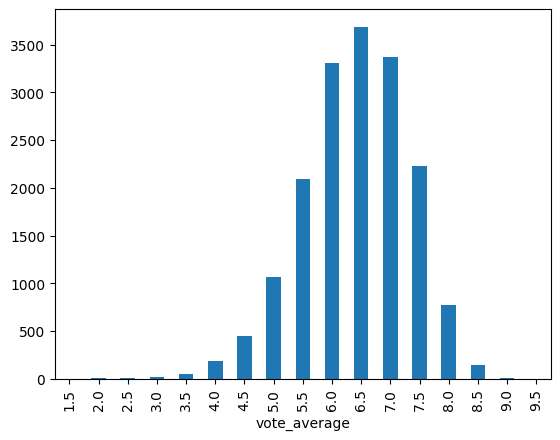

In [41]:
# Map 'vote_average' to nearest 0.5
df['vote_average'] = ((df['vote_average'] * 2).round() / 2)
print(df['vote_average'].value_counts().sort_index().plot(kind='bar'))

In [42]:
#Group vote_average into categories:
# 0.0-5.0 -> bad
# 5.5-6.0 -> mediocre
# 6.5-7.0 -> good
# 7.5-9.9 -> great

# Define the bins and labels
bins = [0.0, 5.0, 6.0, 7.0, 9.9]
labels = ['bad', 'mediocre', 'good', 'great']

# Group vote_average into categories
df['category'] = pd.cut(df['vote_average'], bins=bins, labels=labels, right=True)

# Display the DataFrame
print(df['category'].value_counts())

category
good        7064
mediocre    5407
great       3160
bad         1794
Name: count, dtype: int64


In [43]:
print(df.info())
print("Duplicates: " + str(df.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
Index: 17425 entries, 0 to 17425
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   adult                  17425 non-null  int64   
 1   belongs_to_collection  17425 non-null  object  
 2   budget                 17425 non-null  int64   
 3   genres                 17425 non-null  object  
 4   original_language      17425 non-null  object  
 5   overview               17425 non-null  object  
 6   popularity             17425 non-null  float64 
 7   production_companies   17425 non-null  object  
 8   production_countries   17425 non-null  object  
 9   revenue                17425 non-null  int64   
 10  runtime                17425 non-null  float64 
 11  spoken_languages       17425 non-null  object  
 12  status                 17425 non-null  object  
 13  tagline                17425 non-null  object  
 14  video                  17425 non-null  int6

In [57]:
X = df.drop(columns=['vote_average', 'category'])
# Drop text columns
# X = X.drop(columns=['belongs_to_collection', 'tagline', 'overview'])
Y = df['category']


In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Encode target variable (y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  13940
Test set size:  3485


# Feature encoding

In [59]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 17425 entries, 0 to 17425
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  17425 non-null  int64  
 1   belongs_to_collection  17425 non-null  object 
 2   budget                 17425 non-null  int64  
 3   genres                 17425 non-null  object 
 4   original_language      17425 non-null  object 
 5   overview               17425 non-null  object 
 6   popularity             17425 non-null  float64
 7   production_companies   17425 non-null  object 
 8   production_countries   17425 non-null  object 
 9   revenue                17425 non-null  int64  
 10  runtime                17425 non-null  float64
 11  spoken_languages       17425 non-null  object 
 12  status                 17425 non-null  object 
 13  tagline                17425 non-null  object 
 14  video                  17425 non-null  int64  
 15  vote_co

In [60]:
print(X.head())

   adult belongs_to_collection  budget         genres original_language  \
0      0                  None       0  Drama,Western                en   
1      0                  None       0    Documentary                fr   
2      0                  None       0        History                it   
3      0                  None       0          Drama                en   
4      0                  None       0        Western                en   

                                            overview  popularity  \
0  A fiercely independent cowboy arranges to have...       8.262   
1  Documents the lives of infamous fakers Elmyr d...       7.830   
2  While on holiday in Rhodes, Athenian war hero ...       9.668   
3  In early 1960s London, barrister Melville Farr...       5.896   
4  Respected black cavalry Sergeant Brax Rutledge...       6.003   

                                production_companies  \
0                                   Joel Productions   
1                           

In [63]:
# Define numerical, categorical, boolean, and text features
from sklearn.pipeline import FunctionTransformer


numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month', 'release_day']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

list_transformer = Pipeline(steps=[
    ('to_string', FunctionTransformer(list_to_str, validate=False)),
    ('countvec', CountVectorizer(tokenizer=lambda x: x.split(','), max_features=100))  # Adjust max_features as needed
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', list_transformer, 'genres'),
        ('production_companies', list_transformer, 'production_companies'),
        ('production_countries', list_transformer, 'production_countries'),
        ('cast', list_transformer, 'cast'),
        ('directors', list_transformer, 'directors')
    ]
)



# Opaque models

## SVM

In [69]:
clf = svm.SVC(gamma='auto')

# Define your pipeline with preprocessor
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', clf)
])

svm_pipeline.fit(X_train, Y_train_encoded)
Y_pred = svm_pipeline.predict(X_test)

# Convert predicted labels back to original categories
Y_pred_labels = label_encoder.inverse_transform(Y_pred)

accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

# Optionally: Check predicted labels
print("Predicted labels:", Y_pred_labels)

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy:  0.49440459110473456


In [71]:
# Optionally: Check predicted labels
print("Predicted labels:", Y_pred_labels)

Predicted labels: ['good' 'good' 'good' ... 'mediocre' 'good' 'good']


In [76]:
print(Y_test.value_counts())

category
good        1398
mediocre    1098
great        642
bad          348
Name: count, dtype: int64


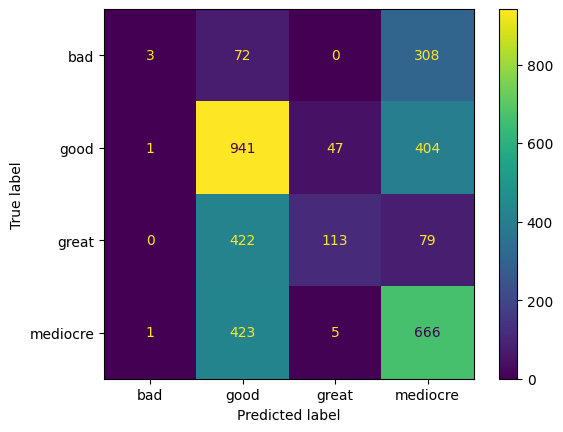

In [73]:
# Print confusion matrix for the model
cm = confusion_matrix(Y_test_encoded, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()